# Digit Recognizer - Baseline Solution

**Kaggle Competition**: [Digit Recognizer](https://www.kaggle.com/competitions/digit-recognizer)

Классификация рукописных цифр MNIST с использованием CNN (PyTorch)

## Содержание
1. Загрузка и исследование данных
2. Предобработка данных
3. Построение CNN модели
4. Обучение
5. Предсказания и submission

## 1. Импорты и настройки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

# Настройки
RANDOM_SEED = 42
BATCH_SIZE = 64
EPOCHS = 15
LEARNING_RATE = 0.001

# Устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Устройство: {device}')

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

Устройство: cuda


/home/yast/PycharmProjects/kaggle/digit_recognizer/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Загрузка данных

In [2]:
# Путь к данным (для Kaggle Kernel)
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

print(f'Train shape: {train_df.shape}')
print(f'Test shape: {test_df.shape}')

Train shape: (42000, 785)
Test shape: (28000, 784)


In [3]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3. Исследование данных (EDA)

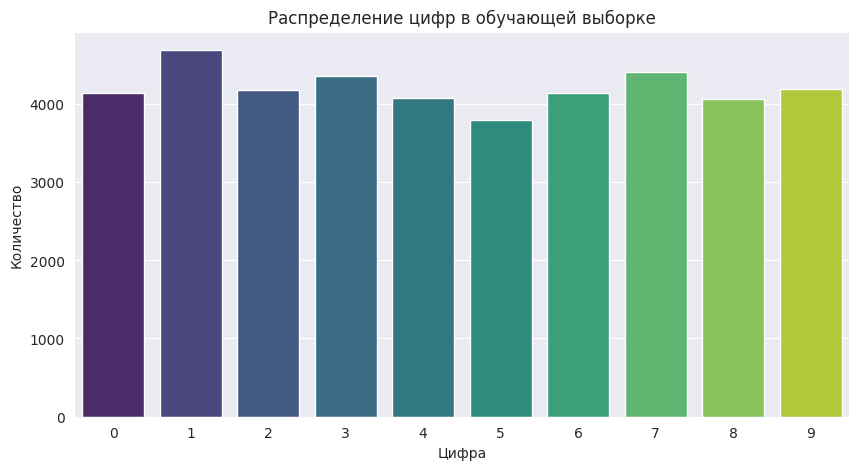

Распределение классов:
label
0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: count, dtype: int64


In [4]:
# Распределение классов
plt.figure(figsize=(10, 5))
sns.countplot(x='label', data=train_df, palette='viridis')
plt.title('Распределение цифр в обучающей выборке')
plt.xlabel('Цифра')
plt.ylabel('Количество')
plt.show()

print('Распределение классов:')
print(train_df['label'].value_counts().sort_index())

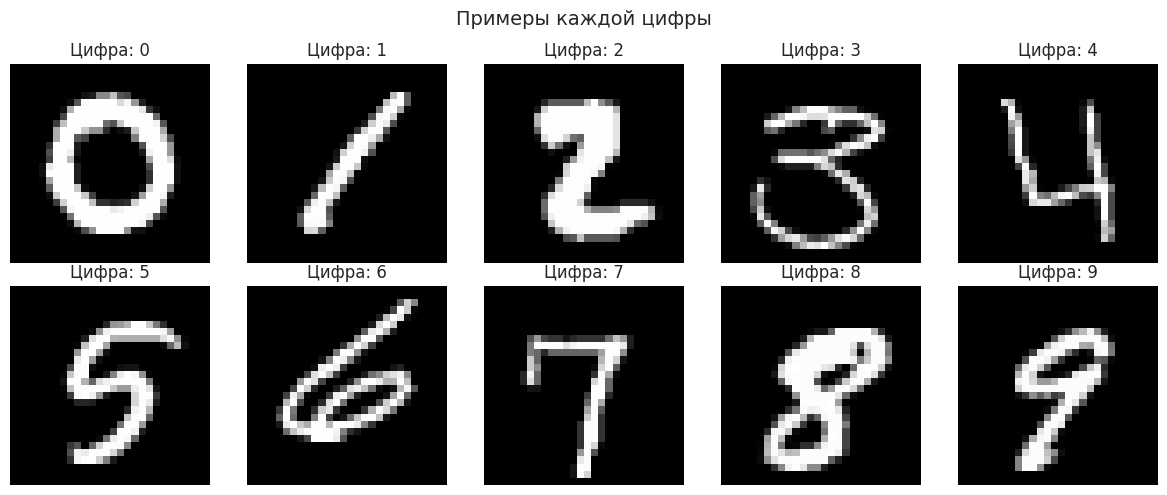

In [5]:
# Визуализация примеров
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for digit in range(10):
    ax = axes[digit // 5, digit % 5]
    sample = train_df[train_df['label'] == digit].iloc[0, 1:].values
    ax.imshow(sample.reshape(28, 28), cmap='gray')
    ax.set_title(f'Цифра: {digit}')
    ax.axis('off')

plt.suptitle('Примеры каждой цифры', fontsize=14)
plt.tight_layout()
plt.show()

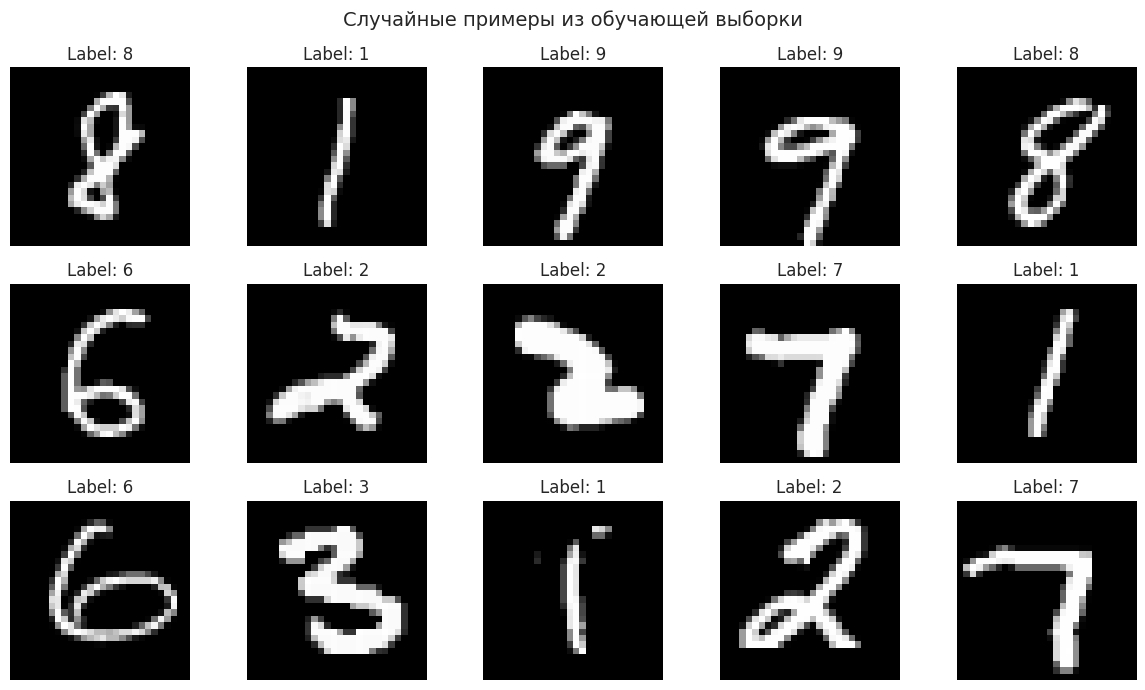

In [6]:
# Случайные примеры
fig, axes = plt.subplots(3, 5, figsize=(12, 7))

random_indices = np.random.choice(len(train_df), 15, replace=False)

for idx, ax in zip(random_indices, axes.flatten()):
    image = train_df.iloc[idx, 1:].values.reshape(28, 28)
    label = train_df.iloc[idx, 0]
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.suptitle('Случайные примеры из обучающей выборки', fontsize=14)
plt.tight_layout()
plt.show()

## 4. Предобработка данных

In [7]:
# Разделение на признаки и метки
X = train_df.drop('label', axis=1).values
y = train_df['label'].values

X_test = test_df.values

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')
print(f'X_test shape: {X_test.shape}')

X shape: (42000, 784)
y shape: (42000,)
X_test shape: (28000, 784)


In [8]:
# Нормализация [0, 255] -> [0, 1]
X = X / 255.0
X_test = X_test / 255.0

# Reshape для CNN: (N, C, H, W)
X = X.reshape(-1, 1, 28, 28)
X_test = X_test.reshape(-1, 1, 28, 28)

print(f'X shape after reshape: {X.shape}')
print(f'X_test shape after reshape: {X_test.shape}')

X shape after reshape: (42000, 1, 28, 28)
X_test shape after reshape: (28000, 1, 28, 28)


In [9]:
# Train/Validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=RANDOM_SEED, stratify=y
)

print(f'Train: {X_train.shape}')
print(f'Validation: {X_val.shape}')

Train: (37800, 1, 28, 28)
Validation: (4200, 1, 28, 28)


In [10]:
# Создание PyTorch DataLoader
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## 5. CNN Модель

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Свёрточные слои
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Batch Normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Pooling и Dropout
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        
        # Полносвязные слои
        # После 3 max pooling: 28 -> 14 -> 7 -> 3
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)  # 28 -> 14
        x = self.dropout1(x)
        
        # Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)  # 14 -> 7
        x = self.dropout1(x)
        
        # Block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)  # 7 -> 3
        x = self.dropout1(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # FC layers
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        
        return x

In [12]:
# Инициализация модели
model = CNN().to(device)
print(model)

# Подсчёт параметров
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nВсего параметров: {total_params:,}')
print(f'Обучаемых параметров: {trainable_params:,}')

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

Всего параметров: 390,858
Обучаемых параметров: 390,858


In [14]:
# Loss и Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

## 6. Обучение модели

In [15]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(loader), 100. * correct / total


def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(loader), 100. * correct / total

In [16]:
# Обучение
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Scheduler step
    scheduler.step(val_loss)
    
    # История
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Сохранение лучшей модели
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
    
    print(f'Epoch [{epoch+1}/{EPOCHS}] | '
          f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | '
          f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')

print(f'\n🏆 Лучшая Val Accuracy: {best_val_acc:.2f}%')

Epoch [1/15] | Train Loss: 0.3108 | Train Acc: 90.14% | Val Loss: 0.0555 | Val Acc: 98.19%
Epoch [2/15] | Train Loss: 0.1029 | Train Acc: 96.85% | Val Loss: 0.0461 | Val Acc: 98.67%
Epoch [3/15] | Train Loss: 0.0834 | Train Acc: 97.48% | Val Loss: 0.0514 | Val Acc: 98.67%
Epoch [4/15] | Train Loss: 0.0726 | Train Acc: 97.84% | Val Loss: 0.0341 | Val Acc: 99.10%
Epoch [5/15] | Train Loss: 0.0620 | Train Acc: 98.18% | Val Loss: 0.0387 | Val Acc: 98.95%
Epoch [6/15] | Train Loss: 0.0586 | Train Acc: 98.26% | Val Loss: 0.0322 | Val Acc: 99.05%
Epoch [7/15] | Train Loss: 0.0529 | Train Acc: 98.33% | Val Loss: 0.0322 | Val Acc: 98.98%
Epoch [8/15] | Train Loss: 0.0490 | Train Acc: 98.56% | Val Loss: 0.0294 | Val Acc: 99.17%
Epoch [9/15] | Train Loss: 0.0452 | Train Acc: 98.62% | Val Loss: 0.0342 | Val Acc: 99.29%
Epoch [10/15] | Train Loss: 0.0439 | Train Acc: 98.60% | Val Loss: 0.0296 | Val Acc: 99.12%
Epoch [11/15] | Train Loss: 0.0408 | Train Acc: 98.81% | Val Loss: 0.0300 | Val Acc: 99.2

## 7. Визуализация результатов обучения

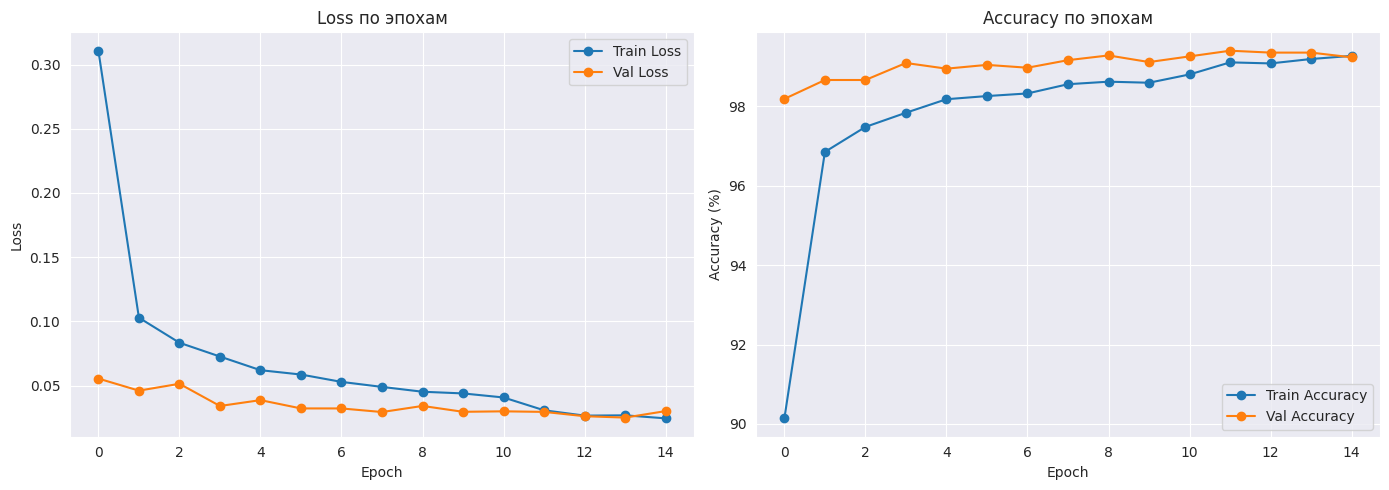

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss по эпохам')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o')
axes[1].plot(history['val_acc'], label='Val Accuracy', marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Accuracy по эпохам')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 8. Анализ ошибок

In [18]:
from sklearn.metrics import confusion_matrix, classification_report

# Загрузка лучшей модели
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Предсказания на валидации
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

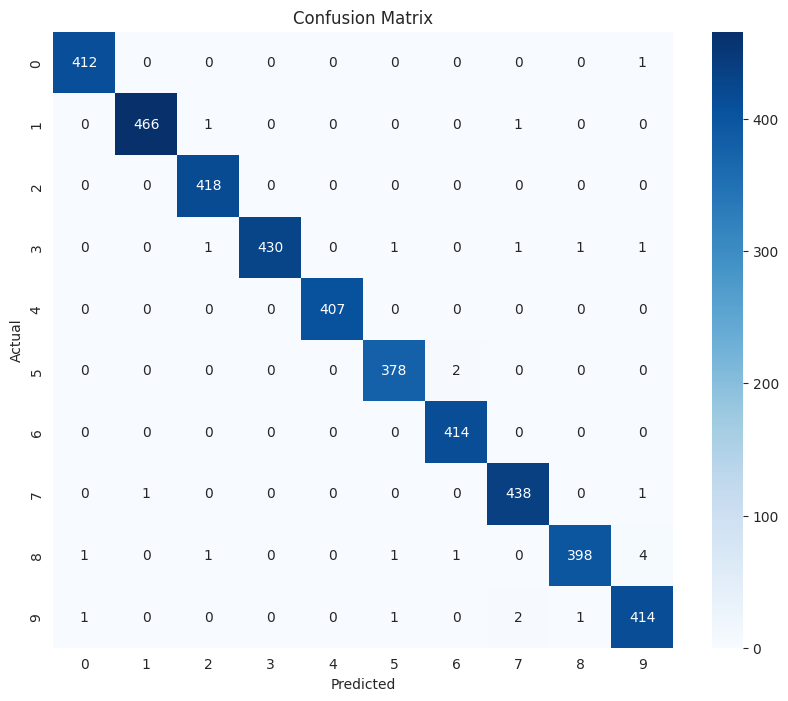

In [19]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [20]:
# Classification Report
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       413
           1       1.00      1.00      1.00       468
           2       0.99      1.00      1.00       418
           3       1.00      0.99      0.99       435
           4       1.00      1.00      1.00       407
           5       0.99      0.99      0.99       380
           6       0.99      1.00      1.00       414
           7       0.99      1.00      0.99       440
           8       0.99      0.98      0.99       406
           9       0.98      0.99      0.99       419

    accuracy                           0.99      4200
   macro avg       0.99      0.99      0.99      4200
weighted avg       0.99      0.99      0.99      4200



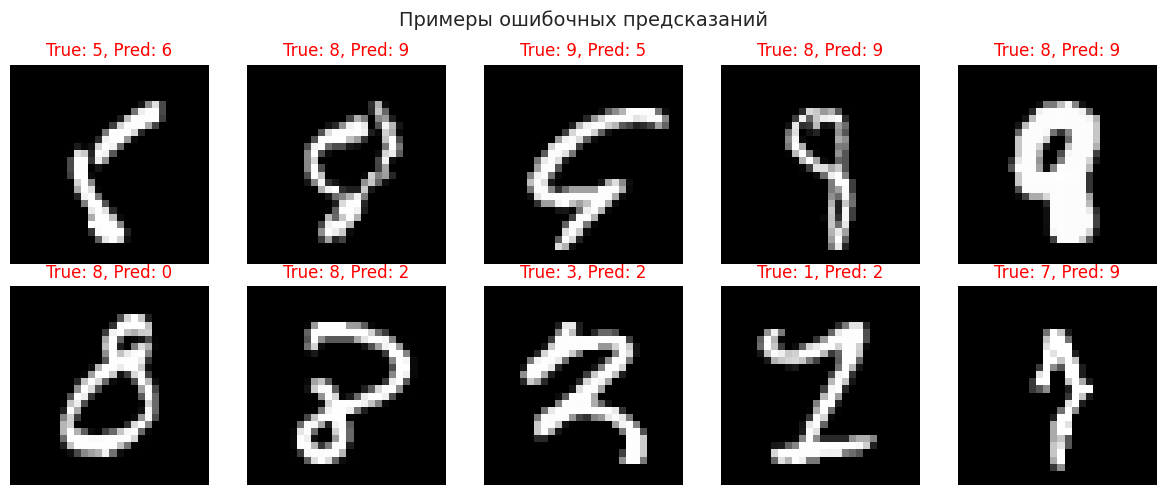

In [21]:
# Визуализация ошибочных предсказаний
errors_idx = np.where(all_preds != all_labels)[0]

if len(errors_idx) > 0:
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    
    for i, ax in enumerate(axes.flatten()):
        if i < len(errors_idx):
            idx = errors_idx[i]
            image = X_val[idx].reshape(28, 28)
            ax.imshow(image, cmap='gray')
            ax.set_title(f'True: {all_labels[idx]}, Pred: {all_preds[idx]}', color='red')
        ax.axis('off')
    
    plt.suptitle('Примеры ошибочных предсказаний', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print('Все предсказания верные!')

## 9. Предсказания на тестовых данных и submission

In [22]:
# Предсказания
model.eval()
predictions = []

with torch.no_grad():
    for (inputs,) in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        predictions.extend(preds.cpu().numpy())

predictions = np.array(predictions)
print(f'Всего предсказаний: {len(predictions)}')

Всего предсказаний: 28000


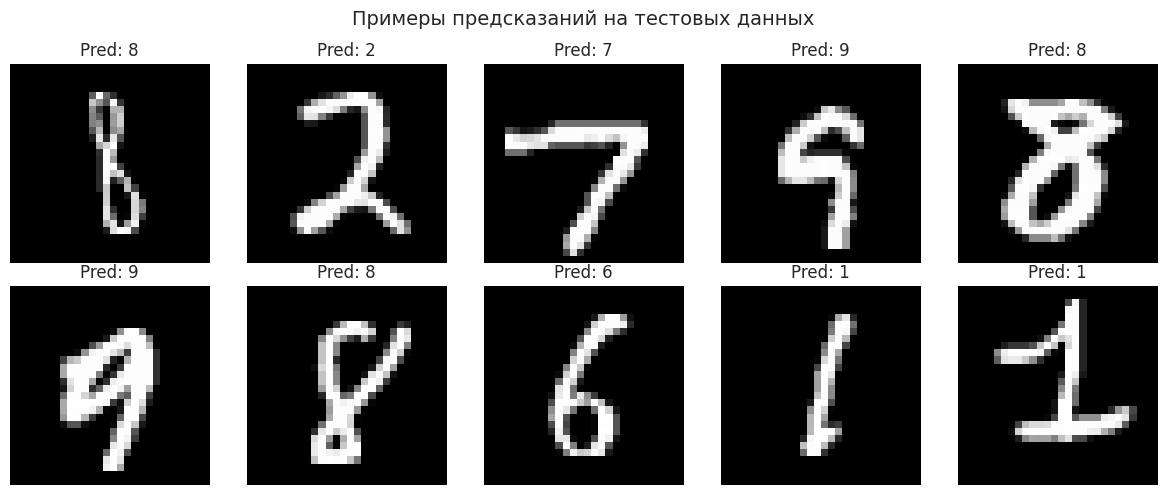

In [23]:
# Визуализация предсказаний
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

random_test_indices = np.random.choice(len(X_test), 10, replace=False)

for i, ax in enumerate(axes.flatten()):
    idx = random_test_indices[i]
    image = X_test[idx].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Pred: {predictions[idx]}')
    ax.axis('off')

plt.suptitle('Примеры предсказаний на тестовых данных', fontsize=14)
plt.tight_layout()
plt.show()

In [24]:
# Создание submission файла
submission = pd.DataFrame({
    'ImageId': range(1, len(predictions) + 1),
    'Label': predictions
})

submission.to_csv('submission.csv', index=False)
print('✅ submission.csv создан!')
submission.head(10)

✅ submission.csv создан!


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3


In [25]:
# Проверка submission
print(f'Размер submission: {submission.shape}')
print(f'\nРаспределение предсказанных классов:')
print(submission['Label'].value_counts().sort_index())

Размер submission: (28000, 2)

Распределение предсказанных классов:
Label
0    2783
1    3197
2    2822
3    2769
4    2770
5    2514
6    2751
7    2910
8    2730
9    2754
Name: count, dtype: int64


## 10. Итоги и дальнейшие улучшения

### Что сделано:
- ✅ EDA и визуализация данных
- ✅ CNN модель с BatchNorm и Dropout
- ✅ Обучение с learning rate scheduler
- ✅ Анализ ошибок (Confusion Matrix)
- ✅ Создание submission файла

### Идеи для улучшения:
1. **Data Augmentation** - повороты, сдвиги, масштабирование
2. **Более глубокая архитектура** - ResNet, EfficientNet
3. **Ensemble** - объединение нескольких моделей
4. **Cross-Validation** - более надёжная оценка
5. **Pseudo-labeling** - использование тестовых данных
6. **Hyperparameter tuning** - Optuna, Ray Tune